In [26]:
import math as m
import warnings

warnings.filterwarnings("ignore")

from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import qiskit_ibm_runtime

In [2]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend('ibm_kyoto')

## Step 1: Map classical inputs to a quantum problem

In [18]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

#### Specific Grover's Instance

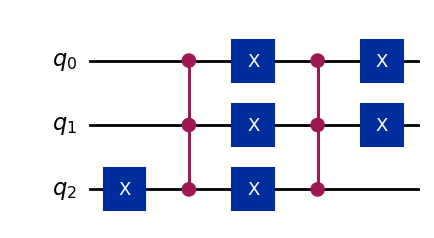

In [19]:
marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

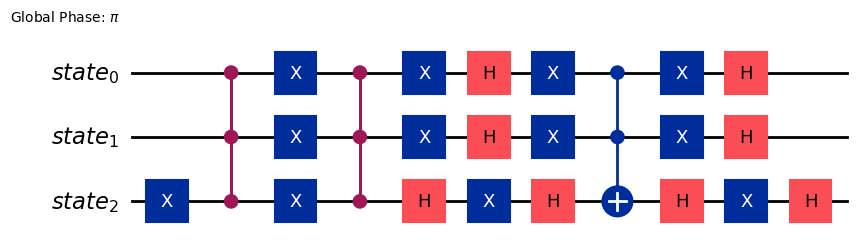

In [20]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [21]:
optimal_num_iterations = m.floor(
    m.pi / (4 * m.asin(m.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

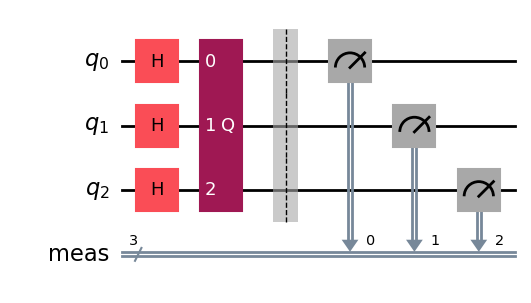

In [22]:
qc = QuantumCircuit(grover_op.num_qubits)

# Create an even superposition of all basis states
qc.h(range(grover_op.num_qubits))

# Apply Grover operation the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)

# Measure
qc.measure_all()
qc.draw(output="mpl", style="iqp")

## Step 2: Optimise Problem for Quantum Execution

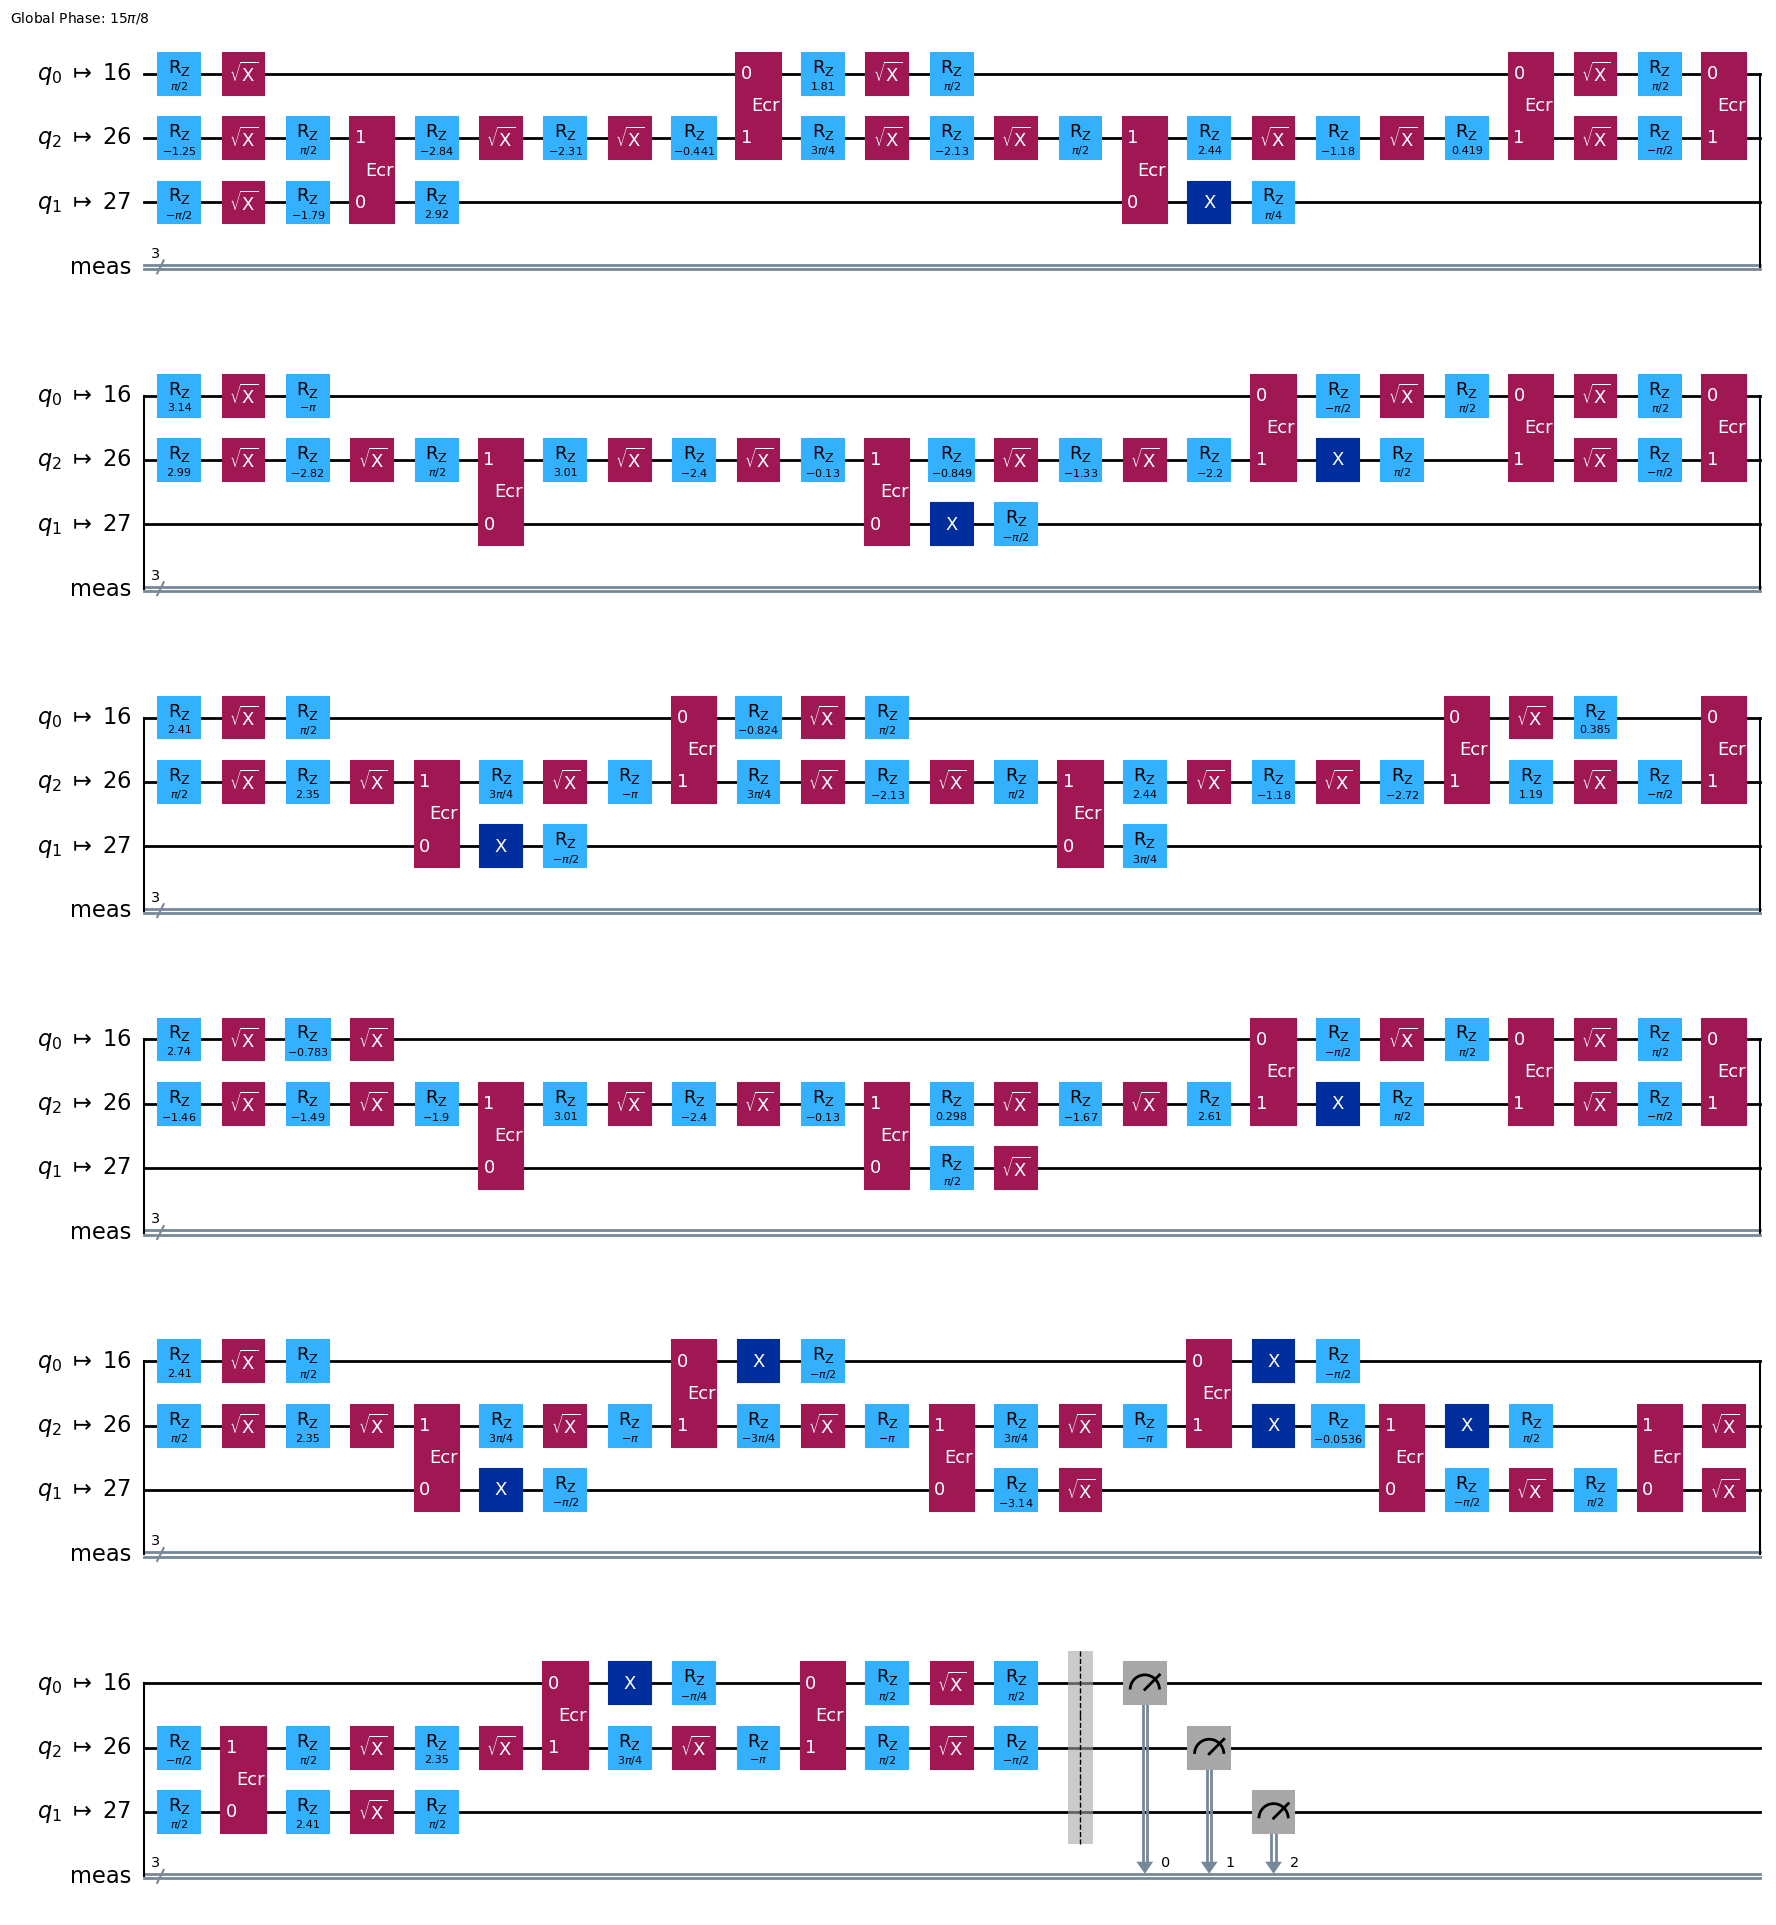

In [23]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

## Step 3: Execute using Qiskit Primitives

In [24]:
sampler = Sampler(backend=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

base_runtime_job._start_websocket_client:WARNING:2024-04-27 18:05:59,564: An error occurred while streaming results from the server for job crpt1sztbrm0008p5j7g:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/qiskit_ibm_runtime/api/clients/base_websocket_client.py", line 222, in stream
    raise WebsocketError(error_message)
qiskit_ibm_runtime.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection. Error: Traceback (most recent call last):\n 

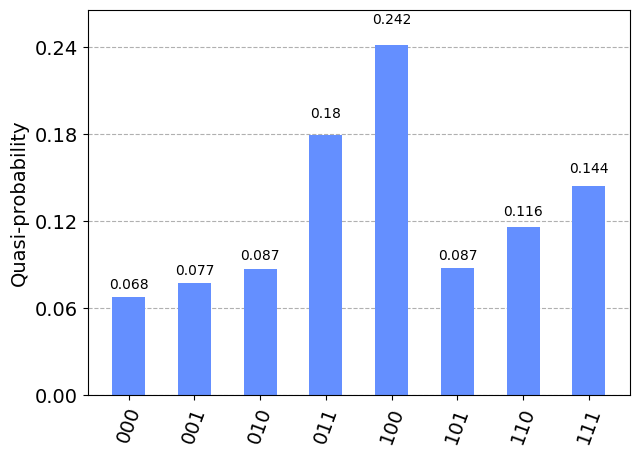

In [25]:
plot_distribution(dist)